### Forest structure using PDAL + Python

Dr Adam Steer, November 2019.

This work is a set of python modules to replace MATLAB code for generating TERN forest metrics from airborne LIDAR.

## Fundamental ideas

Existing code uses a series of nested loops, meaning we can't take advantage of array operations or easily reformat or paralellise functionality

The approach used here defines a transportable function for each TERN product. These are applied to the data using a single loop (which could be chunked and parallelised).

A simple process step-through looks like:

1. Read LAS tile using PDAL. This removes an uncompression step. It also removes low outliers and computes normalised height for each point on the fly
2. Read numpy labelled arrays from PDAL output into a GeoPandas dataframe, and apply a 2D spatial index
3. From LAS file metadata, produce a fishnet grid with cells of size 'output resolution X output resolution'
4. Iterate over grid cells, select valid points and generate TERN products for each grid cell
5. Assemble an output array for each TERN product and write to GeoTIFF

This set of functions operates per-las-tile. An additional layer may be added to merge mutliple raster outputs into larger datasets

## to do:

- snake_casify variable names

In [1]:
NODATA_VALUE = -9999

In [2]:
#imports
import pdal
import numpy as np
import json

from shapely.geometry import Point
from shapely.geometry import MultiPolygon
from shapely.geometry import box
#from shapely.strtree import STRtree

import geopandas as gpd
import pandas as pd
import osmnx as ox

import os

# not using this, using geopandas instead
from rtree import index

# this is needed to create a raster from the output array
from osgeo import gdal
import osgeo.osr as osr

In [3]:
def writegeotiff(griddedpoints, outfile, parameters):
    """
    writes out a geotiff from a numpy array of forest metric
    results.
    
    inputs:
    - a numpy array of metrics [griddedpoints]
    - an outfile name [outfile]
    - a dictionary of parameters for the raster
    
    outputs:
    - a gdal dataset object
    - [outfile] written to disk
    """
    
    width = parameters["width"]
    height = parameters["height"]
    
    drv = gdal.GetDriverByName("GTiff")
    ds = drv.Create(outfile, width, height, 6, gdal.GDT_Float32)
    ds.SetGeoTransform(parameters["upperleft_y"],
                       parameters["resolution"],
                       0,
                       parameters["upperleft_y"],
                       0,
                       parameters["resolution"])
    ds.setProjection = parameters["projection"]
    ds.GetRasterBand(1).WriteArray(arr)

    return(ds)

def pdal2df(points):
    """
    Feed me a PDAL pipeline return array, get back a 
    GeoPandas dataframe 
    """

    arr = points[0]
    description = arr.dtype.descr
    cols = [col for col, __ in description]
    gdf = gpd.GeoDataFrame({col: arr[col] for col in cols})
    gdf.name = 'nodes'
    gdf['geometry'] = gdf.apply(lambda row: Point((row['X'], row['Y'])), axis=1)
    
    return(gdf_nodes)

def spatialindex(dataframe):
    sindex = dataframe.sindex
    return(sindex)

#get a pointview from PDAL
def readlasfile(lasfile):
    """
    Run a PDAL pipeline. Input is a JSON declaration to 
    deliver to PDAL. Output is a labelled numpy array.
    
    Data are filtered to:
    - label local minima as noise
    - compute height above ground using nearest ground point
      neighbours (TIN method arriving soon)
    - sort using a morton order (space filling curve) to 
      speed indexing later.
    
    """
    pipeline = {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": lasfile
            },
            {
                "type": "filters.hag"
            }
        ]
    }
    
    pipeline = pdal.Pipeline(json.dumps(pipeline))
    count = pipeline.execute()
    
    #read points into labelled arrays
    arrays = pipeline.arrays

    #return a numpy array to operate on
    return(arrays)

def readlasmetadata(lasfile):
    pipeline = {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": lasfile,
                "count": 1
            },
            {
                "type": "filters.info"
            }
        ]
    }
    
    pipeline = pdal.Pipeline(json.dumps(pipeline))
    pipeline.validate()
    pipeline.loglevel = 2  # stay quiet
    count = pipeline.execute()
    
    #extract metadata into a JSON blob
    metadata = json.loads(pipeline.metadata)
    
    return(metadata)


def readlaschunk(lasfile, poly):
    """
    Run a PDAL pipeline to collect a chunk of points from a LASfile.
    
    Inputs
    - a PDAL readable file name
    - a geometry bounding the chunk of data to be clipped
    
    Output
    - a labelled numpy array.

    
    """
    xmin = str(np.int(np.floor(poly.bounds[0])))
    ymin = str(np.int(np.floor(poly.bounds[1])))
    xmax = str(np.int(np.ceil(poly.bounds[2])))
    ymax = str(np.int(np.ceil(poly.bounds[3])))
    
    cropbox = "([" + xmin + "," + ymin + "],[" + xmax + "," + ymax + "])"
    print(cropbox)
    
    pipeline = {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": lasfile
            },
            {
                "type": "filters.crop",
                "bounds": cropbox
            }
        ]
    }
    
    pipeline = pdal.Pipeline(json.dumps(pipeline))
    count = pipeline.execute()

    #read points into labelled arrays
    array = pipeline.arrays

    #return a numpy array to operate on
    return(array)


def extract_vars(df):
    """
    extract relevant variables
    do we need to do this now? or wait till we've grabbed the indexed chunk?
    lets write it anyway, then the index chunkifier can call it...
    
    inputs:
    - a numpy labelled array resulting from a PDAL LAS/LAZ file read
    
    outputs:
    - 1D arrays containing relevant variables
    
    """
    classification = df["Classification"].values
    intensity = df["Intensity"].values
    returnnumber = df["ReturnNumber"].values
    numberofreturns = df["NumberOfReturns"].values
    elevation = df["Z"].values
    hag = df["HeightAboveGround"].values

    return(intensity, returnnumber, numberofreturns, elevation, hag)


def gen_raster_cells(metadata, resolution):
    """
    Generate cells of 'resolution x resolution' for point querying
    
    input:
    - PDAL metadata
    
    output:
    - shapely geometry containing polygons defining 'resolution x resolution'
      boxes covering the LAS tile extent
      
    """
    bbox = box(metadata["metadata"]["readers.las"][0]["minx"],
               metadata["metadata"]["readers.las"][0]["miny"],
               metadata["metadata"]["readers.las"][0]["maxx"],
               metadata["metadata"]["readers.las"][0]["maxy"])
    
    tiledBBox = ox.quadrat_cut_geometry(bbox, quadrat_width=resolution)
    
    return(tiledBBox)

def get_cell_points(poly, df, sindex):
    
    poly = poly.buffer(1e-14).buffer(0)
    possible_matches_index = list(sindex.intersection(poly.bounds))
    possible_matches = df.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(poly)]
    
    return(precise_matches)

In [4]:
# Vegetation cover fraction: (Nfirst - Nsingle) / Nfirst
def comp_vcf(points):
    """
    Computes vegetation cover fraction according to the TERN product manual.
    
    inputs:
    - a labelled array of points from an input LAS tile
    
    outputs:
    - a numpy array of grid cells containing the result of:
    
    (Nfirst - Nsingle) / Nfirst
    
    ...where:
    Nfirst = count of first returns
    Nsingle = count of single returns
    
    ...per grid cell.
    """
    # collect all the first and single return indices
    nSingle = np.size(np.where(points["NumberOfReturns"].values == 1))
    nFirst = np.size(np.where(points["ReturnNumber"].values == 1))
    if (nFirst > 0):
        vcf = (nFirst - nSingle) / nFirst
    else:
        print('no first returns, set vcf to {}'.format(NODATA_VALUE))
        vcf = -9999
        
    return(vcf)

In [5]:
# Canopy layering index:

# R = total returns
# 

In [6]:
# vegetation layer cover fraction: LCF

def comp_lcf(points, heights, vcf):
    """
    Compute LCF as per the TERN product manual:
    
    LCF = VCF * (((veg returns below H2) - (veg returns below H1)) / (veg returns below H2))
    
    Inputs:
    - a set of points to compute LCF over
    - a height threshold pair, containing H1 and H2 as an array [h1, h2]
    - a precomputed VCF
    
    Outputs:
    - a floating point number denoting LCF
    
    Conditions:
    
    The LCF *must* be computed over the same set of points as the VCF used as input.
    
    """
    
    h1 = heights[0]
    h2 = heights[1]
    
    #find veg returns - ASPRS classes 3,4,5
    veg_returns = np.where(np.logical_or(points["Classification"].values == 3,
                             points["Classification"].values == 4,
                             points["Classification"].values == 5))
    # how many veg returns have height below the first threshold?
    vegbelowh1 = np.size(np.where(points["HeightAboveGround"][vegreturns] < h1))
    
    # how many veg returns have height below the second threshold?
    vegbelowh2 = np.size(np.where(points["HeightAboveGround"][vegreturns] < h2))
    
    # compute the LCF
    lcf = vcf * ( (vegbelowh2 - vegbelowh1) / vegbelowh2)
    
    return(lcf)


In [7]:
#CTH
def comp_cth(points):
    # compute the highest vegetation point in each grid cell
    
    veg_returns = np.where(np.logical_or(points["Classification"].values == 3,
                             points["Classification"].values == 4,
                             points["Classification"].values == 5)) 

    vegpoints = points["HeightAboveGround"].values[veg_returns]

    cth = np.max(vegpoints)

    return(cth)

In [8]:
def comp_dem(points):
    # interpolate ground returns in a grid and output a raster
    
    
    return()

In [9]:
def comp_fbf(points):
    # if building classes exist, compute a fractional conver per grid cell...
    
    return()

In [10]:
def read_data(lasfile):
    """
    wrapper to read in LAS data and produce a dataframe + spatial index
    """
    metadata, points = readlasfile(lasfile)
    
    dataframe, spatial_index = pdal2df(points)
    
    return(metadata, dataframe, spatial_index)
    

In [11]:
def compute_tern_products(metadata, points, sindex, resolution):
    """
    Wrapper to iterate over the input data and generate rasters for each product.
    
    *note this part could be paralellised - maybe per-product, or per-cell
    
    Each grid square processed in this loop corresponds to one pixel in an output raster.
    
    """
    
    #set up an 'output resolution' sized grid - like a fishnet grid.
    # each polygon in the resulting set covers an area of 'resolution X resolution'
    pixel_grid = gen_raster_cells(metadata, resolution)
    
    #set up output rasters
    
    # get tile width and height
    tile_width = metadata["metadata"]["readers.las"][0]["maxx"] - metadata["metadata"]["readers.las"][0]["minx"]
    tile_height = metadata["metadata"]["readers.las"][0]["maxy"] - metadata["metadata"]["readers.las"][0]["miny"]

    raster_xsize = int(np.ceil(tile_width) / resolution)
    raster_ysize = int(np.ceil(tile_height) / resolution)
    
    print(tile_width)
    print(raster_xsize)
    
    vcf_raster = np.zeros((raster_xsize, raster_ysize))
    
    print(np.shape(vcf_raster))

    lcf_raster = np.zeros((raster_xsize, raster_ysize))
    cth_raster = np.zeros((raster_xsize, raster_ysize))
    
    
    for pixel in pixel_grid:
        
        #compute output array index for this cell:
        
        poly_x, poly_y = pixel.centroid.xy
        
        poly_base_x = poly_x[0] - metadata["metadata"]["readers.las"][0]["minx"]
        poly_base_y = poly_y[0] - metadata["metadata"]["readers.las"][0]["miny"]
        
        print(poly_base_x)
        print(poly_base_y)
        
        array_x = int(np.floor((poly_base_x / (resolution)) ))
        array_y = int(np.floor((poly_base_y / (resolution)) ))
        
        #print('array X: {}; array Y: {}'.format(array_x, array_y))
        
        #get points for this cell
        matches = get_cell_points(pixel, points, sindex)
        
        #compute in order
        #VCF
        vcf_raster[array_x, array_y] = comp_vcf(matches)
        
        #LCF - need stuff about levels here...
        #lcf_raster[array_x, array_y] = comp_lcf(points)
        
        #CTH
        try:
            cth_raster[array_x, array_y] = comp_cth(matches)
        except ValueError:
            print('no vegetation returns were present, CTH set to {} for array index {} {}'.format(NODATA_VALUE, array_x, array_y))
            cth_raster[array_x, array_y] = NODATA_VALUE
            
    #end of computing stuff
    
    #extract EPSG code from LAS:

    
    return(vcf_raster, cth_raster)

## Testing functionality using a local file
The following section generates metrics from a local LAZ file. Plugging in download mechanics from ELVIS will be added later

In [16]:
#lidar test file - Mt Ainslie, chosen for varied vegetation cover and topography
# this is pretty big, may need splitting up!

#lasfile = "/Volumes/Antares/ACT-lidar/8ppm/callingelvis-testdata/ACT2015_8ppm-C3-AHD_6966094_55.las"


In [16]:
lasfile = "/Volumes/Antares/fire-test/NSW Government - Spatial Services-2/Point Clouds/AHD/StAlbans201709-LID2-C3-AHD_2866308_56_0002_0002/StAlbans201709-LID2-C3-AHD_2866308_56_0002_0002.las"

In [17]:
lasfile = "./Berridale201802-LID2-C3-AHD_6585974_55_0002_0002.las"

In [18]:
%%time

metadata = readlasmetadata(lasfile)

CPU times: user 113 ms, sys: 51.1 ms, total: 164 ms
Wall time: 198 ms


In [19]:
metadata

{'metadata': {'': [{}, {}],
  'filters.info': [{'bbox': {'maxx': 658000.04,
     'maxy': 5975675.97,
     'maxz': 1083.073,
     'minx': 658000.04,
     'miny': 5975675.97,
     'minz': 1083.073},
    'dimensions': 'X, Y, Z, Intensity, ReturnNumber, NumberOfReturns, ScanDirectionFlag, EdgeOfFlightLine, Classification, ScanAngleRank, UserData, PointSourceId, GpsTime',
    'num_points': 1,
    'schema': {'dimensions': [{'name': 'X', 'size': 8, 'type': 'floating'},
      {'name': 'Y', 'size': 8, 'type': 'floating'},
      {'name': 'Z', 'size': 8, 'type': 'floating'},
      {'name': 'Intensity', 'size': 2, 'type': 'unsigned'},
      {'name': 'ReturnNumber', 'size': 1, 'type': 'unsigned'},
      {'name': 'NumberOfReturns', 'size': 1, 'type': 'unsigned'},
      {'name': 'ScanDirectionFlag', 'size': 1, 'type': 'unsigned'},
      {'name': 'EdgeOfFlightLine', 'size': 1, 'type': 'unsigned'},
      {'name': 'Classification', 'size': 1, 'type': 'unsigned'},
      {'name': 'ScanAngleRank', 'size': 

In [20]:
resolution = 25

In [21]:
pixel_grid = gen_raster_cells(metadata, resolution)

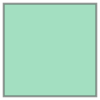

In [22]:
pixel_grid[0]

In [24]:
boxbounds = pixel_grid[0].bounds[0]

In [25]:
boxbounds

658000.000000025

In [26]:
#get a pointview from PDAL
def readlaschunk(lasfile, poly):
    """
    Run a PDAL pipeline to collect a chunk of points from a LASfile.
    
    Inputs
    - a PDAL readable file name
    - a geometry bounding the chunk of data to be clipped
    
    Output
    - a labelled numpy array.

    
    """
    xmin = str(np.int(np.floor(poly.bounds[0])))
    ymin = str(np.int(np.floor(poly.bounds[1])))
    xmax = str(np.int(np.ceil(poly.bounds[2])))
    ymax = str(np.int(np.ceil(poly.bounds[3])))
    
    cropbox = "([" + xmin + "," + ymin + "],[" + xmax + "," + ymax + "])"
    print(cropbox)
    
    pipeline = {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": lasfile
            },
            {
                "type": "filters.crop",
                "bounds": cropbox
            }
        ]
    }
    
    pipeline = pdal.Pipeline(json.dumps(pipeline))
    count = pipeline.execute()

    #read points into labelled arrays
    array = pipeline.arrays

    #return a numpy array to operate on
    return(array)

In [27]:
%%time

laschunk = readlaschunk(lasfile, pixel_grid[0])

([658000,5975975],[658025,5976000])
CPU times: user 2.92 s, sys: 152 ms, total: 3.08 s
Wall time: 3.08 s


In [28]:
laschunk

[array([(658000.04, 5975675.97, 1083.073, 21, 1, 1, 1, 0, 12, -22., 1, 13, 2.02784424e+08),
        (658000.16, 5975675.94, 1083.023, 20, 1, 1, 1, 0, 12, -22., 1, 13, 2.02784424e+08),
        (658000.26, 5975675.92, 1082.993, 21, 1, 1, 1, 0, 12, -22., 1, 13, 2.02784424e+08),
        ...,
        (659998.88, 5975994.72,  953.323, 16, 1, 1, 0, 0, 12, -19., 0, 14, 2.02785090e+08),
        (659999.  , 5975998.23,  952.922, 19, 1, 1, 1, 0, 12, -19., 0, 14, 2.02785090e+08),
        (659999.52, 5975999.01,  952.852, 17, 1, 1, 0, 0, 12, -19., 0, 14, 2.02785090e+08)],
       dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('ReturnNumber', 'u1'), ('NumberOfReturns', 'u1'), ('ScanDirectionFlag', 'u1'), ('EdgeOfFlightLine', 'u1'), ('Classification', 'u1'), ('ScanAngleRank', '<f4'), ('UserData', 'u1'), ('PointSourceId', '<u2'), ('GpsTime', '<f8')])]

In [29]:
%%time

laspoints = readlasfile(lasfile)

CPU times: user 8.43 s, sys: 208 ms, total: 8.64 s
Wall time: 8.62 s


In [ ]:
%%time

#here we read points into a GeoDataFrame and dump the labelled array.
# this is a pretty expensive step RAM wise, we're duplicating all the points...

df = pdal2df(laspoints)

In [ ]:
# set points to None, we don't use them anymore
laspoints = None

In [ ]:
%%time

sindex = spatialindex(df)

In [13]:
# dump everything from memory
points = None
df = None
vcf_raster = None
cth_raster = None

In [14]:
%%time
# this part of the process is simply reading from the source file. No analysis yet.

metadata, points = readlasfile(lasfile)

CPU times: user 10min 30s, sys: 26.2 s, total: 10min 56s
Wall time: 11min 5s


In [68]:
%%time

#here we read points into a GeoDataFrame and dump the labelled array.
# this is a pretty expensive step RAM wise, we're duplicating all the points...

df = pdal2df(points)

# set points to None, we don't use them anymore
points = None

NameError: name 'points' is not defined

In [ ]:
%%time

# here we generate an RTree index on the dataframe using GeoPandas.
# also pretty expensive... 

sindex = spatialindex(df)

In [ ]:
%%time
## rtree index building straight from the point dataset...

idx = index.Index()
for pid, point in enumerate(points[0]):
    idx.insert(pid, (point[0], point[1],point[0], point[1]), point)

In [7]:
# set an output resolution

resolution = 100

In [ ]:
%%time

vcf_raster, cth_raster = compute_tern_products(metadata, df, sindex, resolution)

In [ ]:
from matplotlib import pyplot as plt

%matplotlib inline

In [ ]:
plt.imshow(vcf_rasters)
plt.colorbar()

In [ ]:
plt.imshow(cth_rasters)
plt.colorbar()

In [ ]:
wktcrs = metadata["metadata"]["readers.las"][0]["comp_spatialreference"]

In [ ]:
type(wktcrs)

In [ ]:
srs = osr.SpatialReference()

In [ ]:
srs.SetFromUserInput("EPSG:28356")

In [ ]:
srs.ImportFromWkt(wktcrs)

In [ ]:
srs.GetAuthorityCode(None)

In [ ]:
srs.GetAuthorityName(None)

In [ ]:
tiledBBox = gen_raster_cells(metadata,resolution)

In [ ]:
tiledBBox[50]

In [ ]:
%%time
idxpoints, tree = create_spatial_index(points)

In [ ]:
%%time
thepoints = tree.query(geometry_cut[50])

In [ ]:
query

## Run a sample workflow on one square

In [ ]:
pixel_grid[0]

In [ ]:
matches = get_cell_points(pixel_grid[10],df, sindex)

In [ ]:
def comp_cth1(points):
    # compute the highest vegetation point in each grid cell
    
    veg_returns = np.where(np.logical_or(points["Classification"].values == 3,
                             points["Classification"].values == 4,
                             points["Classification"].values == 5)) 

    vegpoints = points["HeightAboveGround"].values[veg_returns]

    cth = np.max(vegpoints)
    
    return(cth)

In [ ]:
comp_cth1(matches)

## create a dataframe for pretty querying purposes..

In [ ]:
points

In [ ]:
#import pandas as pd



In [ ]:


#points = None

In [ ]:
# find the points that intersect with each subpolygon and add them to points_within_geometry
points_within_geometry = pd.DataFrame()

In [ ]:
def get_points(poly, df, sindex):
    poly = poly.buffer(1e-14).buffer(0)
    possible_matches_index = list(sindex.intersection(poly.bounds))
    possible_matches = df.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(poly)]
    
    return(precise_matches)

In [ ]:
polyX, polyY = poly.centroid.xy

In [ ]:
polyX

In [ ]:
polyY

In [ ]:
polyBaseXCoord = polyX[0] - metadata["metadata"]["readers.las"][0]["minx"]

In [ ]:
arrayXindex = (polyBaseXCoord / (resolution/2 )) -1
arrayXindex

In [ ]:
polyBaseYCoord = polyY[0] - metadata["metadata"]["readers.las"][0]["miny"]

In [ ]:
arrayYindex = (polyBaseYCoord / (resolution/2 )) - 1 
arrayYindex

In [ ]:
arrayX = PolyBaseCoord - numberofcells

In [ ]:
polyY[0] - metadata["metadata"]["readers.las"][0]["miny"]

In [ ]:
tilewidth = metadata["metadata"]["readers.las"][0]["maxx"] - metadata["metadata"]["readers.las"][0]["minx"]
tilewidth

In [ ]:
tileheight = metadata["metadata"]["readers.las"][0]["maxy"] - metadata["metadata"]["readers.las"][0]["miny"]
tileheight

In [ ]:
vcfRaster = np.zeros((tilewidth, tileheight))

In [ ]:
vcfRaster

In [ ]:
%%time 

matches = get_points(poly, df)

In [ ]:
matches

In [ ]:
intensity, returnnumber, numberofreturns, elevation, hag  = extract_vars(matches)

In [ ]:
np.size(np.where(matches["NumberOfReturns"].values == 1))

In [ ]:
## OK now we can make magic - extracting each grid cell, we can rasterify it...

In [ ]:
vcf = comp_vcf(matches)

In [ ]:
vcf

In [ ]:
vcfRaster[0,138] = vcf

In [ ]:
vcfRaster

In [ ]:
this = matches["Classification"].values

In [ ]:
veg = np.where(np.logical_or(matches["Classification"].values == 3,matches["Classification"].values == 4, matches["Classification"].values == 5)) 

In [ ]:
this = matches["Classification"].values

In [ ]:
np.where(matches["HeightAboveGround"].values[veg] < 1)

In [ ]:
lcf0105 = comp_lcf(matches, [1, 5], vcf)

## code purgatory
stuff here might be useful, or not

In [ ]:
# this will likely evolve to take a 'what to grid' input
# actually likely not needed...
def grid_setup(pointmetadata, resolution):
    """
    Sets up array indexes for an incoming las file, using an input resolution
    
    input:
    - las file metadata
    - a scalar resolution
    
    output:
    - a numpy array of indexing values to divide the input points into
      'resolution' x 'resolution' bins.
      
    implicit assumptions:
    - 'resolution' is always set in native LAS file units
    """
    
    return()

In [ ]:
# not used yet - geopandas is doing this part!
def create_spatial_index(arrays):
    """
    task here is to map geospatial space to numpy array space.
    
    - using the point metadata set up a grid of [resolution] x [resolution]
    - scan the point coordinates array to see which points live in which cell
    - create an index which maps point array indexes to grid indexes
    
    idly wondering if a fast point-in-polygon does this job. Shapely / OGR to the rescue?
    ...this would be parallelisable...
    """
    points = []
    
    for thepoint in arrays[0]:
        #print(thepoint[0])
        points.append(Point(thepoint[0], thepoint[1]))
    
    tree = STRtree(points)
    
    return(points, tree)

